In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.font_manager as fm

from statsmodels.stats.multitest import multipletests

from itertools import combinations, chain
import upsetplot

import json

import helper

import config
config.config_visuals()

# Define experiments

In [2]:
with open("experiments.json", "r") as f:
    exp = json.load(f)

    experiments = exp["experiments"]
    experiment_ids = exp["experiment_ids"]
    display_names = exp["display_names"]
    display_groups = exp["display_groups"]
    contexts = exp["contexts"]

# Load TPMS and sleuth results

In [3]:
kallisto_sleuth_path = "../data/processed/kallisto_sleuth_merge/"

rpl22_oe_genes = pd.read_hdf(
    kallisto_sleuth_path + "rpl22_oe_genes.h5", key="sleuth_diff"
)
rpl22l1_oe_genes = pd.read_hdf(
    kallisto_sleuth_path + "rpl22l1_oe_genes.h5", key="sleuth_diff"
)
rpl22l1_kd1_genes = pd.read_hdf(
    kallisto_sleuth_path + "rpl22l1_kd1_genes.h5", key="sleuth_diff"
)
rpl22l1_kd2_genes = pd.read_hdf(
    kallisto_sleuth_path + "rpl22l1_kd2_genes.h5", key="sleuth_diff"
)
rpl22_a_ko1_genes = pd.read_hdf(
    kallisto_sleuth_path + "rpl22_a_ko1_genes.h5", key="sleuth_diff"
)
rpl22_a_ko2_genes = pd.read_hdf(
    kallisto_sleuth_path + "rpl22_a_ko2_genes.h5", key="sleuth_diff"
)
rpl22_b_ko1_genes = pd.read_hdf(
    kallisto_sleuth_path + "rpl22_b_ko1_genes.h5", key="sleuth_diff"
)
rpl22_b_ko2_genes = pd.read_hdf(
    kallisto_sleuth_path + "rpl22_b_ko2_genes.h5", key="sleuth_diff"
)

rpl22_oe_transcripts = pd.read_hdf(
    kallisto_sleuth_path + "rpl22_oe_transcripts.h5", key="sleuth_diff"
)
rpl22l1_oe_transcripts = pd.read_hdf(
    kallisto_sleuth_path + "rpl22l1_oe_transcripts.h5", key="sleuth_diff"
)
rpl22l1_kd1_transcripts = pd.read_hdf(
    kallisto_sleuth_path + "rpl22l1_kd1_transcripts.h5", key="sleuth_diff"
)
rpl22l1_kd2_transcripts = pd.read_hdf(
    kallisto_sleuth_path + "rpl22l1_kd2_transcripts.h5", key="sleuth_diff"
)
rpl22_a_ko1_transcripts = pd.read_hdf(
    kallisto_sleuth_path + "rpl22_a_ko1_transcripts.h5", key="sleuth_diff"
)
rpl22_a_ko2_transcripts = pd.read_hdf(
    kallisto_sleuth_path + "rpl22_a_ko2_transcripts.h5", key="sleuth_diff"
)
rpl22_b_ko1_transcripts = pd.read_hdf(
    kallisto_sleuth_path + "rpl22_b_ko1_transcripts.h5", key="sleuth_diff"
)
rpl22_b_ko2_transcripts = pd.read_hdf(
    kallisto_sleuth_path + "rpl22_b_ko2_transcripts.h5", key="sleuth_diff"
)

In [30]:
# a_transcripts = rpl22_a_ko1_transcripts[rpl22_a_ko1_transcripts["qval"]<0.01].index
# b_transcripts = rpl22_a_ko2_transcripts[rpl22_a_ko2_transcripts["qval"]<0.01].index

a_transcripts = rpl22l1_kd1_transcripts[rpl22l1_kd1_transcripts["qval"]<0.01]
b_transcripts = rpl22l1_kd2_transcripts[rpl22l1_kd2_transcripts["qval"]<0.01]

common = list(set(a_transcripts.index)&set(b_transcripts.index))
# a_transcripts.loc[common]["hgnc_gene"]
print("\n".join(list(a_transcripts.loc[common]["hgnc_gene"].dropna())))

GPX1
SORL1
FBXW11
SRSF2
GGCT
STX6
MEX3C
TMEM63C
UBE2B
SNRPA
TCEB2
RB1
TMPO
TUBB2A
CYHR1
TCEB2
TUBA1B
UBN2
CEL
CCND1
LSS
PCNT
TIMM8B
TRIM2
BOD1
TTC27
MMP24
SGMS2
DHTKD1
GPT2
SPC24
SEC11C
SERF2
DDX17
SLC45A3
DEFB132
RPS14
C1orf86
KIAA1191
NCAM2
TOLLIP
VPS26A
DDR1
QKI
EBP
ERGIC1
HSPB8
TTC17
CA12
DEPDC1B
GTPBP2
FANCA
ZNF429
CCNA2
CHPF2
ID3
UGT2B11
DIAPH1
RXRA
RPS19
RPL34
SNRPN
ZBED4
PCK2
DDC
H1FX
PPM1A
EIF2B2
CHDH
FYCO1
SLC5A6
LINC00537
MGLL
TUBB
TM9SF4
HGS
PANX1
ZMAT3
BTF3
KIAA1522
RPS27L
NPEPPS
KIFC1
DDOST
CDKN2C
CD63
CHRNA5
CES2
ABCC1
ELL2
ST14
RAB21
APOBEC3B
TNFRSF19
IQGAP2
TMEM109
KIAA0101
ASCC3
PPIL4
PBK
CRY1
BET1L
JUNB
MAPRE3
LPIN2
PIDD
TMEM170A
PLK3
SLC27A2
TRIM65
TRAFD1
PPL
HOXC13
MAN1A1
DDX39A
IQGAP3
ZXDC
TMSB4X
TMX4
H2AFV
RFK
TFDP1
MRPS14
TUBA3D
TRIM25
NAAA
TUSC2
SLC19A2
PCNXL4
WIPI2
RBM4
MVB12B
TXNL1
LAMA5
TRIAP1
AGO2
HPCAL1
SH3BGRL3
OAS3
TLE1
ZXDC
PPP2R1B
ZSCAN4
PC
CCM2
ZNF703
MVK
NT5DC3
BCAT2
ARF3
ATP6V0E2
ANO6
AP2B1
ZNF511
FAM114A1
MMAB
CNTNAP2
DUSP3
CEP55
PYCRL
PDDC1
RPL34


In [39]:
print("\n".join(list(rpl22l1_kd2_transcripts[rpl22l1_kd2_transcripts["qval"]<10e-50]["hgnc_gene"].dropna())))

SAT1
CDKN1A
RPN2
BTG2
IGFBP3
FOXD4
PHGDH
SCD
SNN
RPL22L1
RPS27L
ZMAT3
PCK2
RAB3D
CSNK1G1
SESN2
SERPINB5
CES2
FAM65B
ELL2
DDB2
DAP
IQGAP3
PNP
MCCC2
MCCC2
KIAA0247
NXPH4
RPL10A
SFTPA2
XPC
SYT7
TRIM35
GABRB3
RCN1
PHLDA3
SUCLG2
CA12
MDM2
IRS1
RPS27L
ATPIF1
HMOX1
TUBA1B
RRBP1
TSPYL4
CCNB2
RAP2B
OGDH
PLK1
FDXR
TAX1BP3
ITGA5
PRAMEF7
PRAMEF13
SPRYD4
PPM1D


# Differential expression

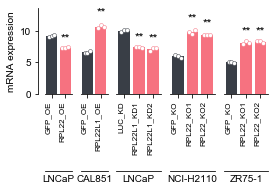

In [31]:
helper.all_bars("ENSG00000163584", "gene")

plt.savefig(
    "../plots/RPL22L1_ENSG00000163584_expression.pdf",
    bbox_inches="tight",
    transparent=True,
)

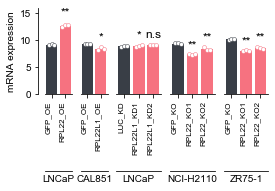

In [32]:
helper.all_bars("ENSG00000116251", "gene")

plt.savefig(
    "../plots/RPL22_ENSG00000116251_expression.pdf",
    bbox_inches="tight",
    transparent=True,
)

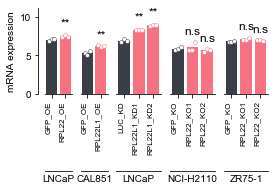

In [34]:
helper.all_bars("ENSG00000135679", "gene")

plt.savefig(
    "../plots/MDM2_ENSG00000135679_expression.pdf",
    bbox_inches="tight",
    transparent=True,
)

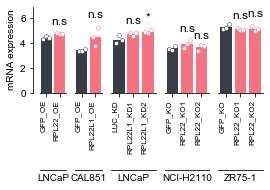

In [33]:
helper.all_bars("ENSG00000198625", "gene")

plt.savefig(
    "../plots/MDM4_ENSG00000198625_expression.pdf",
    bbox_inches="tight",
    transparent=True,
)

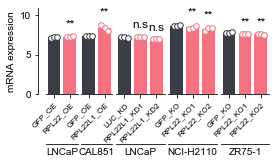

In [10]:
helper.all_bars("ENSG00000143569", "gene")

plt.savefig(
    "../plots/UBAP2L_ENSG00000143569_expression.pdf",
    bbox_inches="tight",
    transparent=True,
)

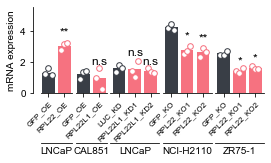

In [11]:
helper.all_bars("ENST00000484819", "transcript")

plt.savefig(
    "../plots/UBAP2L_ENST00000484819_expression.pdf",
    bbox_inches="tight",
    transparent=True,
)

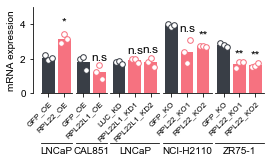

In [12]:
helper.all_bars("ENST00000433615", "transcript")

plt.savefig(
    "../plots/UBAP2L_ENST00000433615_expression.pdf",
    bbox_inches="tight",
    transparent=True,
)

## Volcano plots

# Overlaps

In [35]:
def get_overlaps(diffs, names, cutoff=0.01, direction=None, filter_empty=True):

    assert len(diffs) == len(names), "Length of diffs and names should match"

    n_diffs = len(diffs)
    all_subset_indices = list(
        chain(*[combinations(range(n_diffs), i) for i in range(1, n_diffs + 1)])
    )

    significants = []

    for diff in diffs:

        if direction == None:

            significant = diff.copy(deep=True)[diff["qval"] < cutoff]

        if direction == "pos":

            significant = diff.copy(deep=True)[diff["qval"] < cutoff]
            significant = significant[significant["treatment_increase"] == 1]

        elif direction == "neg":

            significant = diff.copy(deep=True)[diff["qval"] < cutoff]
            significant = significant[significant["treatment_increase"] == -1]

        significant["gene"] = (
            significant["hgnc_gene"].fillna("nan")
            + "_"
            + pd.Series(significant.index, index=significant.index)
        )

        significant_genes = set(significant["gene"])

        significants.append(significant_genes)

    intersections = []
    intersection_names = []

    for subset_indices in all_subset_indices:

        select_significants = set.intersection(
            *[significants[i] for i in subset_indices]
        )

        if len(subset_indices) < n_diffs:

            select_insignificants = set.union(
                *[significants[i] for i in range(n_diffs) if i not in subset_indices]
            )

            select_significants = select_significants - select_insignificants

        select_names = [names[i] for i in subset_indices]

        intersections.append(select_significants)
        intersection_names.append(select_names)

    intersection_sizes = [len(x) for x in intersections]

    if filter_empty:

        n_subsets = len(intersections)

        empty = [len(x) == 0 for x in intersections]

        intersections = [intersections[i] for i in range(n_subsets) if not empty[i]]
        intersection_names = [
            intersection_names[i] for i in range(n_subsets) if not empty[i]
        ]
        intersection_sizes = [
            intersection_sizes[i] for i in range(n_subsets) if not empty[i]
        ]

    return intersections, intersection_names, intersection_sizes

## Between RPL22L1 shRNAs

In [36]:
rpl22_int_rmats = [
    rpl22_b_ko2_transcripts,
    rpl22_b_ko1_transcripts,
    rpl22_a_ko2_transcripts,
    rpl22_a_ko1_transcripts,
    rpl22_oe_transcripts,
]

rpl22_int_display_names = [
    "ZR75-1 RPL22_KO2",
    "ZR75-1 RPL22_KO1",
    "NCI-H2110 RPL22_KO2",
    "NCI-H2110 RPL22_KO1",
    "LNCaP RPL22_OE",
]

rpl22_ko_ints, rpl22_ko_int_names, rpl22_ko_int_sizes = get_overlaps(
    rpl22_int_rmats, rpl22_int_display_names
)

In [61]:
rpl22_ko_ints[-1]

{'RPL22L1_ENST00000295830',
 'RPL22L1_ENST00000463836',
 'RPL22_ENST00000234875',
 'UBAP2L_ENST00000484819'}

In [37]:
rpl22_ko_pivot = upsetplot.from_memberships(rpl22_ko_int_names, rpl22_ko_int_sizes)

rpl22_ko_pivot = rpl22_ko_pivot.reorder_levels(rpl22_int_display_names)

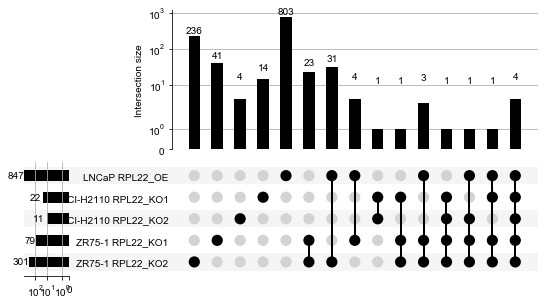

In [56]:
up = upsetplot.plot(rpl22_ko_pivot, sort_categories_by=None, show_counts=True)

up["intersections"].set_yscale("symlog")

# up["intersections"].set_ylim(0.5)

# for patch in up["intersections"]:
#     patch.set_rasterized(True)

plt.savefig(
    "../plots/RPL22_transcript_intersections.pdf",
    transparent=True,
    bbox_inches="tight",
    dpi=25,
)

In [57]:
rpl22l1_int_rmats = [
    rpl22l1_kd2_transcripts,
    rpl22l1_kd1_transcripts,
    rpl22l1_oe_transcripts,
]

rpl22l1_int_display_names = [
    "LNCaP RPL22L1_KD2",
    "LNCaP RPL22L1_KD1",
    "CAL851 RPL22L1_OE",
]

rpl22l1_ko_ints, rpl22l1_ko_int_names, rpl22l1_ko_int_sizes = get_overlaps(
    rpl22l1_int_rmats, rpl22l1_int_display_names
)

In [58]:
rpl22l1_ko_pivot = upsetplot.from_memberships(
    rpl22l1_ko_int_names, rpl22l1_ko_int_sizes
)

rpl22l1_ko_pivot = rpl22l1_ko_pivot.reorder_levels(rpl22l1_int_display_names)

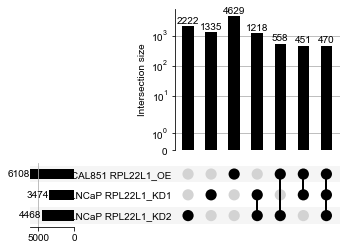

In [60]:
up = upsetplot.plot(rpl22l1_ko_pivot, sort_categories_by=None, show_counts=True)

up["intersections"].set_yscale("symlog")

plt.savefig(
    "../plots/RPL22L1_transcript_intersections.pdf",
    transparent=True,
    bbox_inches="tight",
)

# fgsea results

In [40]:
rpl22_oe_fgsea = pd.read_csv(
    "../data/processed/fgsea_results/rpl22_oe.txt", sep="\t", index_col=0
)
rpl22l1_oe_fgsea = pd.read_csv(
    "../data/processed/fgsea_results/rpl22l1_oe.txt", sep="\t", index_col=0
)
rpl22l1_kd1_fgsea = pd.read_csv(
    "../data/processed/fgsea_results/rpl22l1_kd1.txt", sep="\t", index_col=0
)
rpl22l1_kd2_fgsea = pd.read_csv(
    "../data/processed/fgsea_results/rpl22l1_kd2.txt", sep="\t", index_col=0
)
rpl22_a_ko1_fgsea = pd.read_csv(
    "../data/processed/fgsea_results/rpl22_a_ko1.txt", sep="\t", index_col=0
)
rpl22_a_ko2_fgsea = pd.read_csv(
    "../data/processed/fgsea_results/rpl22_a_ko2.txt", sep="\t", index_col=0
)
rpl22_b_ko1_fgsea = pd.read_csv(
    "../data/processed/fgsea_results/rpl22_b_ko1.txt", sep="\t", index_col=0
)
rpl22_b_ko2_fgsea = pd.read_csv(
    "../data/processed/fgsea_results/rpl22_b_ko2.txt", sep="\t", index_col=0
)


def preprocess_fgsea(fgsea):
    fgsea.sort_values(by="padj", inplace=True)
    fgsea.index = fgsea["pathway"]
    fgsea["gene_set"] = fgsea["pathway"].str.split("_").str[0]
    fgsea["direction"] = fgsea["NES"] > 0


preprocess_fgsea(rpl22_oe_fgsea)
preprocess_fgsea(rpl22l1_oe_fgsea)
preprocess_fgsea(rpl22l1_kd1_fgsea)
preprocess_fgsea(rpl22l1_kd2_fgsea)
preprocess_fgsea(rpl22_a_ko1_fgsea)
preprocess_fgsea(rpl22_a_ko2_fgsea)
preprocess_fgsea(rpl22_b_ko1_fgsea)
preprocess_fgsea(rpl22_b_ko2_fgsea)

# same order as display_names
fgseas = [
    rpl22_oe_fgsea,
    rpl22l1_oe_fgsea,
    rpl22l1_kd1_fgsea,
    rpl22l1_kd2_fgsea,
    rpl22_a_ko1_fgsea,
    rpl22_a_ko2_fgsea,
    rpl22_b_ko1_fgsea,
    rpl22_b_ko2_fgsea,
]

In [100]:
select_names = display_names[:4]
select_gseas = fgseas[:4]

top_n = 4

# top gene sets
top_sets = set()

for gsea in select_gseas:

    top = gsea.sort_values(by="pval").head(top_n)
    top = top[top["padj"] < 0.1]
    top = top.index

    top_sets = top_sets | set(top)

set_count = len(top_sets)
top_sets = list(top_sets)

# get top sets for each gsea

merged_top_gsea = []

experiment_coord = 0

for name, gsea in zip(select_names, select_gseas):
    
    tops = gsea.loc[top_sets]

    tops["experiment"] = name
    tops["experiment_coord"] = experiment_coord
    tops["gene_set_coord"] = range(len(tops))
        
    experiment_coord += 1
    tops = tops.reset_index(drop=True)
    
    merged_top_gsea.append(tops)

merged_top_gsea = pd.concat(merged_top_gsea)
merged_top_gsea = merged_top_gsea.reset_index(drop=True)
merged_top_gsea

def format_set(x):

    x = x.replace("_", " ")

    x = x.replace("GO ", "").replace(" PROCESS", "").capitalize()

    return x

In [86]:
merged_top_gsea["direction"] = merged_top_gsea["direction"].replace(
    {True: "Upregulated", False: "Downregulated"}
)

def get_signed_qval(row):
    if row["direction"] == "Upregulated":
        return -np.log10(row["padj"])
    elif row["direction"] == "Downregulated":
        return np.log10(row["padj"])


merged_top_gsea["signed_qval"] = merged_top_gsea.apply(get_signed_qval, axis=1)

In [88]:
merged_top_gsea[["signed_qval", "pathway", "experiment"]].pivot(
    index="pathway", columns="experiment"
)

signed_qval  \
experiment                                        CAL851 RPL22L1_OE   
pathway                                                               
GO_ALCOHOL_BIOSYNTHETIC_PROCESS                           -0.443883   
GO_CALCIUM_ION_BINDING                                    -1.298034   
GO_CHROMOSOME_SEGREGATION                                 -1.085394   
GO_COLLAGEN_CONTAINING_EXTRACELLULAR_MATRIX               -0.158642   
GO_CONDENSED_CHROMOSOME                                   -0.509020   
GO_ENTERIC_NERVOUS_SYSTEM_DEVELOPMENT                      1.298034   
GO_EXTRACELLULAR_MATRIX                                   -0.195161   
GO_MRNA_METABOLIC_PROCESS                                  0.360017   
GO_POLYMERIC_CYTOSKELETAL_FIBER                           -1.319949   
GO_REGULATION_OF_LIPID_BIOSYNTHETIC_PROCESS               -0.909930   
GO_REGULATION_OF_SMALL_MOLECULE_METABOLIC_PROCESS         -0.110761   
GO_RNA_SPLICING                                            0.227882   
GO_STEROID_BIOSYNTHETIC_PROCESS                           -0.631414   
HALLMARK_G2M_CHECKPOINT                                   -0.909930   
HALLMARK_P53_PATHWAY                                       1.995840   

                                                                     \
experiment                                        LNCaP RPL22L1_KD1   
pathway                                                               
GO_ALCOHOL_BIOSYNTHETIC_PROCESS                           -0.090933   
GO_CALCIUM_ION_BINDING                                    -6.708807   
GO_CHROMOSOME_SEGREGATION                                  4.777754   
GO_COLLAGEN_CONTAINING_EXTRACELLULAR_MATRIX              -13.929678   
GO_CONDENSED_CHROMOSOME                                    1.716233   
GO_ENTERIC_NERVOUS_SYSTEM_DEVELOPMENT                      0.244527   
GO_EXTRACELLULAR_MATRIX                                  -15.099390   
GO_MRNA_METABOLIC_PROCESS                                 13.392676   
GO_POLYMERIC_CYTOSKELETAL_FIBER                           -1.003014   
GO_REGULATION_OF_LIPID_BIOSYNTHETIC_PROCESS                0.111648   
GO_REGULATION_OF_SMALL_MOLECULE_METABOLIC_PROCESS         -0.520506   
GO_RNA_SPLICING                                           13.307985   
GO_STEROID_BIOSYNTHETIC_PROCESS                            0.036596   
HALLMARK_G2M_CHECKPOINT                                    4.742979   
HALLMARK_P53_PATHWAY                                      -1.782810   

                                                                     \
experiment                                        LNCaP RPL22L1_KD2   
pathway                                                               
GO_ALCOHOL_BIOSYNTHETIC_PROCESS                           -9.230027   
GO_CALCIUM_ION_BINDING                                     0.069225   
GO_CHROMOSOME_SEGREGATION                                 -0.055057   
GO_COLLAGEN_CONTAINING_EXTRACELLULAR_MATRIX                0.210060   
GO_CONDENSED_CHROMOSOME                                   -0.073812   
GO_ENTERIC_NERVOUS_SYSTEM_DEVELOPMENT                      0.165659   
GO_EXTRACELLULAR_MATRIX                                    0.210060   
GO_MRNA_METABOLIC_PROCESS                                 -0.226082   
GO_POLYMERIC_CYTOSKELETAL_FIBER                           -0.400403   
GO_REGULATION_OF_LIPID_BIOSYNTHETIC_PROCESS               -8.267813   
GO_REGULATION_OF_SMALL_MOLECULE_METABOLIC_PROCESS         -8.720910   
GO_RNA_SPLICING                                           -0.262275   
GO_STEROID_BIOSYNTHETIC_PROCESS                           -8.267813   
HALLMARK_G2M_CHECKPOINT                                   -0.009637   
HALLMARK_P53_PATHWAY                                       0.210060   

                                                                  
experiment                                        LNCaP RPL22_OE  
pathway                                                           
GO_ALCOHOL_BIOSYNT

In [90]:
merged_top_gsea[merged_top_gsea["pathway"]=="HALLMARK_P53_PATHWAY"]

,pathway,pval,padj,log2err,ES,NES,size,leadingEdge,gene_set,direction,experiment,experiment_coord,gene_set_coord,signed_qval
1,HALLMARK_P53_PATHWAY,9.449825e-02,6.165105e-01,0.287805,0.564540,1.530917,183,"7832,10769,27244,3945,64393,1643,351,4193,6141...",HALLMARK,Upregulated,LNCaP RPL22L1_KD2,0,1,0.210060
16,HALLMARK_P53_PATHWAY,4.866063e-04,1.648884e-02,0.498493,-0.480743,-1.603433,187,"6890,6768,1029,1509,8870,3654,3732,6281,6256,2...",HALLMARK,Downregulated,LNCaP RPL22L1_KD1,1,1,-1.782810
31,HALLMARK_P53_PATHWAY,1.198795e-06,1.009626e-02,0.643552,0.752781,1.909107,180,"1026,27244,7832,4193,22824,64393,51065,23612,6...",HALLMARK,Upregulated,CAL851 RPL22L1_OE,2,1,1.995840
46,HALLMARK_P53_PATHWAY,2.838362e-11,1.205878e-07,0.863415,0.820128,2.131641,185,"6303,1026,51065,7832,64393,4193,5268,1643,581,...",HALLMARK,Upregulated,LNCaP RPL22_OE,3,1,6.918697


In [91]:
rpl22l1_kd2_fgsea

,pathway,pval,padj,log2err,ES,NES,size,leadingEdge,gene_set,direction
pathway,,,,,,,,,,
HALLMARK_G2M_CHECKPOINT,HALLMARK_G2M_CHECKPOINT,1.396950e-12,1.186988e-08,0.910120,-0.803621,-2.001306,190,"9133,6421,5347,4288,11065,6541,991,1164,27338,...",HALLMARK,False
HALLMARK_P53_PATHWAY,HALLMARK_P53_PATHWAY,2.838362e-11,1.205878e-07,0.863415,0.820128,2.131641,185,"6303,1026,51065,7832,64393,4193,5268,1643,581,...",HALLMARK,True
GO_CONDENSED_CHROMOSOME,GO_CONDENSED_CHROMOSOME,1.103232e-06,2.343541e-03,0.643552,-0.710537,-1.770019,189,"5347,4288,891,10615,55839,147841,3014,113130,3...",GO,False
GO_CHROMOSOME_SEGREGATION,GO_CHROMOSOME_SEGREGATION,9.224860e-07,2.343541e-03,0.659444,-0.676408,-1.737270,271,"6421,5347,4288,891,3833,991,3837,10615,55839,8...",GO,False
GO_MITOTIC_NUCLEAR_DIVISION,GO_MITOTIC_NUCLEAR_DIVISION,1.639028e-06,2.785365e-03,0.643552,-0.677241,-1.732411,256,"9133,5347,4288,11065,891,3833,991,27338,3837,1...",GO,False
...,...,...,...,...,...,...,...,...,...,...
GO_AXONEMAL_DYNEIN_COMPLEX_ASSEMBLY,GO_AXONEMAL_DYNEIN_COMPLEX_ASSEMBLY,1.000000e+00,1.000000e+00,0.037900,-0.196557,-0.374254,22,"54919,388389",GO,False
GO_HISTONE_METHYLTRANSFERASE_COMPLEX,GO_HISTONE_METHYLTRANSFERASE_COMPLEX,1.000000e+00,1.000000e+00,0.059331,0.220301,0.522278,84,"390245,3054,11108,121536,9757,54554,6879,26036...",GO,True
GO_CATION_CHANNEL_COMPLEX,GO_CATION_CHANNEL_COMPLEX,1.000000e+00,1.000000e+00,0.033058,-0.227237,-0.542193,124,"389816,54795,6844,2017,26047,6340,5311,3757,29...",GO,False


In [77]:
qval_mat = merged_top_gsea[["signed_qval", "pathway", "experiment"]].pivot(
    index="pathway", columns="experiment"
)

from scipy.cluster.hierarchy import linkage, optimal_leaf_ordering, leaves_list

linkage_mat = linkage(qval_mat, method="ward")

leaf_order = optimal_leaf_ordering(linkage_mat, qval_mat)

ordering = leaves_list(leaf_order)

ValueError: The condensed distance matrix must contain only finite values.

In [48]:
gene_set_coords = list(np.argsort(ordering)) * len(select_names)
merged_top_gsea["gene_set_coord"] = gene_set_coords

top_sets = list(np.array(top_sets)[ordering])

# merged_top_gsea["gene_set"] = np.array(top_sets)[gene_set_coords]

(-0.5, 14.5)

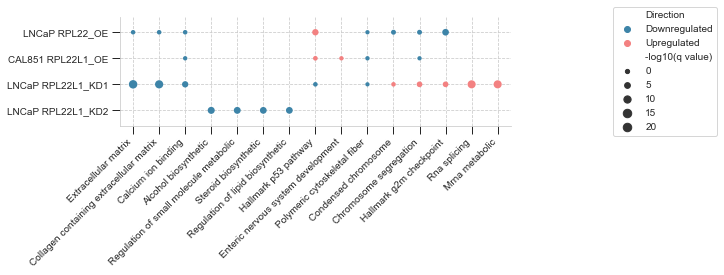

In [49]:
sns.set_style(
    "whitegrid", {"grid.linestyle": "--", "xtick.bottom": True, "ytick.left": True}
)

plt.figure(figsize=(7, 2))
ax = plt.subplot(111)

merged_top_gsea = merged_top_gsea[merged_top_gsea["qval"] < 0.1]

set_labels = [format_set(x) for x in top_sets]

# for i in np.arange(0, len(set_labels), 2)+0.5:
#     ax.axvspan(i-1, i, facecolor='lightgrey', alpha=0.333, zorder=-1)

g = sns.scatterplot(
    merged_top_gsea["gene_set_coord"],
    merged_top_gsea["experiment_coord"],
    size=-np.log10(merged_top_gsea["qval"]).rename("-log10(q value)"),
    hue=merged_top_gsea["direction"].rename("Direction"),
    ax=ax,
    palette={"Downregulated": "#3d84a8", "Upregulated": "#f38181"},
    linewidth=0,
    alpha=1,
)


g.legend(loc="center left", bbox_to_anchor=(1.25, 0.5), ncol=1)

ax.set_yticks(np.arange(len(select_names)))
ax.set_yticklabels(select_names, rotation=0)
ax.set_xticks(np.arange(len(top_sets)))
ax.set_xticklabels(set_labels, rotation=45, ha="right")
# ax.xaxis.tick_top()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


# ax.grid(which='major',linestyle='-', linewidth='0.5')

ax.set_xlabel("")
ax.set_ylabel("")

# ax.set_aspect('auto')
plt.axis("equal")

ax.set_ylim(-0.5, len(select_names) - 0.5)
ax.set_xlim(-0.5, len(set_labels) - 0.5)

# plt.savefig("../plots/gsea_summary.pdf", bbox_inches="tight", dpi=512, transparent=True)

(-0.5, 17.5)

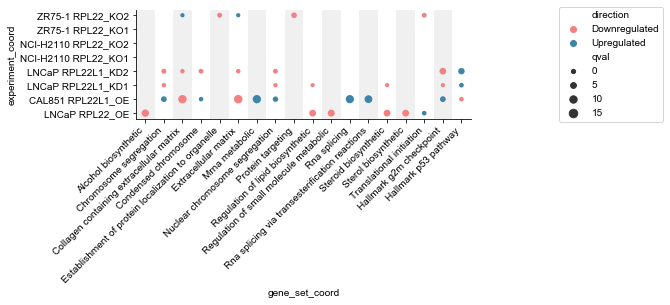

In [124]:
plt.figure(figsize=(6, 2))
ax = plt.subplot(111)

merged_top_gsea = merged_top_gsea[merged_top_gsea["qval"] < 0.1]

set_labels = [format_set(x) for x in top_sets]

for i in np.arange(0, len(set_labels) - 1, 2) + 0.5:
    ax.axvspan(i - 1, i, facecolor="lightgrey", alpha=0.333, zorder=-1)

g = sns.scatterplot(
    merged_top_gsea["gene_set_coord"],
    merged_top_gsea["experiment_coord"],
    size=-np.log10(merged_top_gsea["qval"]),
    hue=merged_top_gsea["direction"],
    ax=ax,
    palette={"Upregulated": "#3d84a8", "Downregulated": "#f38181"},
    linewidth=0,
)

g.legend(loc="center left", bbox_to_anchor=(1.25, 0.5), ncol=1)

ax.set_yticks(np.arange(len(select_names)))
ax.set_yticklabels(select_names, rotation=0)
ax.set_xticks(np.arange(len(top_sets)))
ax.set_xticklabels(set_labels, rotation=45, ha="right")
# ax.xaxis.tick_top()

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlim(-0.5, len(set_labels) - 0.5)